![Add a relevant banner image here](Images/traffic-image.webp)

# Department of Transportation (DOT) Analysis

## Overview

This notebook aims to analyze US traffic accident data to uncover patterns and factors that contribute to accident frequency and severity. The goal is to generate actionable insights for the Department of Transportation and other stakeholders, guiding targeted safety interventions, infrastructure enhancements, and policy recommendations. By examining environmental, geographic, and temporal trends, the analysis supports data-driven decision making to improve road safety and reduce accident impacts.

# Business Understanding

## Analytical Questions
1. What environmental factors are most strongly correlated with traffic accidents?

2. Which geographic regions experience the highest frequency and severity of accidents?

3. How do accident trends vary by time of day, day of the week, and season?

4. What infrastructure or road conditions contribute to accident severity?

5. Can derived features like accident duration or time of occurrence help predict accident severity?

## Benefits and Goals
### Economic Impact
- Reducing accidents can save billions annually in medical costs, property damage, and lost productivity.
### Public Safety
- Identifying and mitigating accident-prone conditions directly improves citizen safety and reduces fatalities.
### Infrastructure Prioritization
- Data-driven insights enable DOT to allocate budgets effectively to high-risk areas.
### Policy Development
- Evidence-based recommendations can inform new safety regulations and evaluate the effectiveness of existing programs.

## Stakeholders
### Primary Stakeholders
- Department of Transportation (DOT): Responsible for implementing policies and infrastructure improvements.
- Congress and Local Governments: Allocate funding and resources based on analysis results.
### Secondary Stakeholders:
- Law Enforcement Agencies: Use insights to improve traffic management and enforcement.
- Emergency Services: Optimize response strategies based on accident patterns.
- Public: Benefit from safer roads and reduced accident rates.

## Data Understanding

In [3]:
# Load relevant imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm


### This project uses [this](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) Kaggle Dataset.
Please place it in the Data directory before running the Notebook.

In [4]:
# Load the dataset
df = pd.read_csv('./Data/US_Accidents_March23.csv')

## Take small portion of the dataset for quick analysis
## Take the first 10% of rows and export to CSV
df_small = df.iloc[:int(len(df) * 0.1)]
df_small.to_csv('./Data/small_US_Accidents_March23.csv', index=False)

In [5]:
# Load the small dataset
df_small = pd.read_csv('./Data/small_US_Accidents_March23.csv')

# Display the first few rows of the small dataset
df_small.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


Missing values in each column:
ID                            0
Source                        0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  772839
End_Lng                  772839
Distance(mi)                  0
Description                   0
Street                     1712
City                         23
County                        0
State                         0
Zipcode                      81
Country                       0
Timezone                    262
Airport_Code                825
Weather_Timestamp          7182
Temperature(F)            11731
Wind_Chill(F)            455716
Humidity(%)               12770
Pressure(in)               9344
Visibility(mi)            15302
Wind_Direction             9179
Wind_Speed(mph)           96007
Precipitation(in)        467302
Weather_Condition         14444
Amenity                       0
Bump     

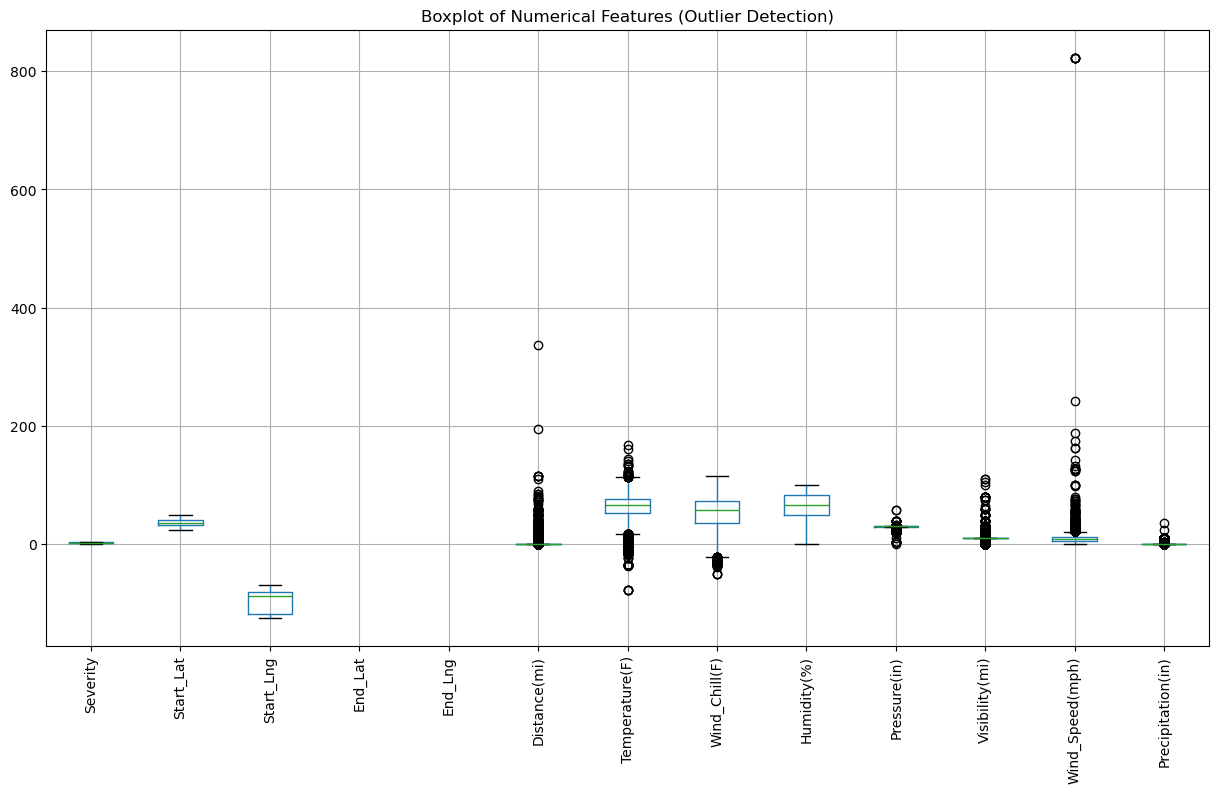

Column 'ID' has 772839 unique values.
Column 'Source' has 2 unique values.
Column 'Start_Time' has 754494 unique values.
Column 'End_Time' has 754343 unique values.
Column 'Description' has 585233 unique values.
Column 'Street' has 73457 unique values.
Column 'City' has 7979 unique values.
Column 'County' has 1339 unique values.
Column 'State' has 47 unique values.
Column 'Zipcode' has 128693 unique values.
Column 'Country' has 1 unique values.
Column 'Timezone' has 5 unique values.
Column 'Airport_Code' has 1637 unique values.
Column 'Weather_Timestamp' has 177814 unique values.
Column 'Wind_Direction' has 25 unique values.
Column 'Weather_Condition' has 105 unique values.
Column 'Amenity' has 2 unique values.
Column 'Bump' has 2 unique values.
Column 'Crossing' has 2 unique values.
Column 'Give_Way' has 2 unique values.
Column 'Junction' has 2 unique values.
Column 'No_Exit' has 2 unique values.
Column 'Railway' has 2 unique values.
Column 'Roundabout' has 2 unique values.
Column 'St

In [6]:
# Assess data quality issues

# Check for missing values
missing_values = df_small.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Check for outliers in numerical columns using boxplots
numerical_cols = df_small.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 8))
df_small[numerical_cols].boxplot(rot=90)
plt.title("Boxplot of Numerical Features (Outlier Detection)")
plt.show()

# Check for inconsistencies (example: unique values in categorical columns)
categorical_cols = df_small.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    unique_vals = df_small[col].unique()
    print(f"Column '{col}' has {len(unique_vals)} unique values.")

## Data Preparation
1. Dropped columns with more than 50% missing values.
2. Imputed missing values for numerical columns with the median and categorical columns with the mode.
3. Removed outliers using the IQR method.
4. Converted date columns to datetime and categorical columns to category type.
5. Created derived features such as `Duration` and `Day_of_Week`.

In [10]:
# Drop columns with more than 50% missing values
threshold = len(df_small) * 0.5
df_cleaned = df_small.dropna(thresh=threshold, axis=1).copy()

# Impute missing values for numerical columns with the median
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[numerical_cols] = df_cleaned[numerical_cols].fillna(df_cleaned[numerical_cols].median())

In [11]:
# Convert date columns to datetime
df_cleaned['Start_Time'] = pd.to_datetime(df_cleaned['Start_Time'])
df_cleaned['End_Time'] = pd.to_datetime(df_cleaned['End_Time'])

# Duration feature
df_cleaned['Duration'] = (df_cleaned['End_Time'] - df_cleaned['Start_Time']).dt.total_seconds() / 3600

# Feature for day of the week
df_cleaned['Day_of_Week'] = df_cleaned['Start_Time'].dt.day_name()

# Convert categorical columns to category type
for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].astype('category')


# Descriptive statistics
print(df_cleaned.describe(include='all'))

            ID   Source       Severity           Start_Time  \
count   772839   772839  772839.000000               772839   
unique  772839        2            NaN               754494   
top        A-1  Source2            NaN  2022-03-11 04:00:16   
freq         1   750126            NaN                   55   
mean       NaN      NaN       2.314940                  NaN   
std        NaN      NaN       0.565226                  NaN   
min        NaN      NaN       1.000000                  NaN   
25%        NaN      NaN       2.000000                  NaN   
50%        NaN      NaN       2.000000                  NaN   
75%        NaN      NaN       3.000000                  NaN   
max        NaN      NaN       4.000000                  NaN   

                   End_Time      Start_Lat      Start_Lng   Distance(mi)  \
count                772839  772839.000000  772839.000000  772839.000000   
unique               754343            NaN            NaN            NaN   
top     2016-10

## Analysis
### Surprising Finding

#### Environmental
- The number of accidents goes up doing good to fair weather conditions. But the severity of the accidents goes up under adverse weather conditions.

#### Accident Frequency by State
- States with high accident frequency may not necessarily have the highest severity levels. This could indicate better emergency response systems or infrastructure in these states, mitigating the impact of accidents.

`This also could be due to using only a small chunk of the data`

#### Accident Frequency by Hour
- The Accident frequency by hour preformed mostly as expected with peaks in accident frequency during rush hours. 

#### Severity vs Distance
- The severity by distance analysis preformed as expected. The severity goes up as the distance traveled goes up.

#### Severity by Day of the Week
- The severity of accidents during the weekend was slightly higher than on the weekdays. I expected to see a dip on Sunday because less people would be on the road. This could indicate that since less people are on the road there are higher speeds leading to mor severity in accidents. This correlation can be supported by the final graph "Number of accidents by day of the week". 

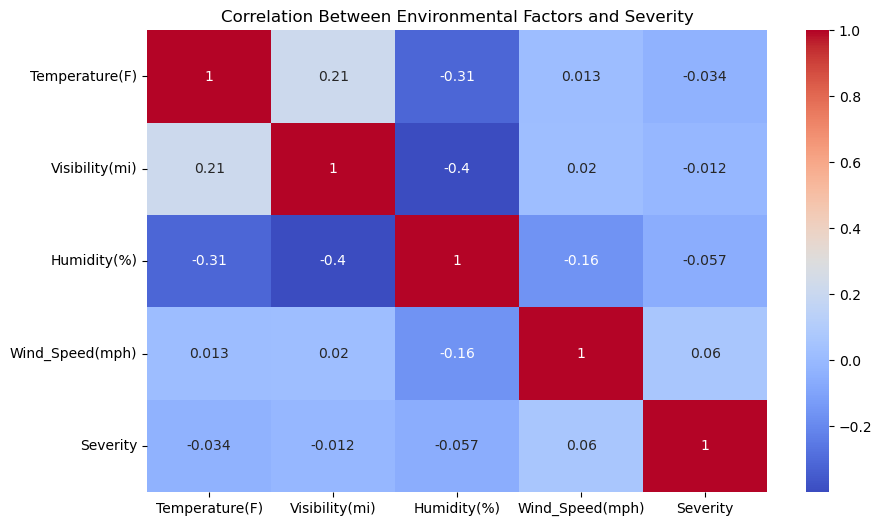

In [12]:
# Correlation heatmap for environmental factors
env_factors = ['Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Humidity(%)', 'Wind_Speed(mph)']
# Only use columns that exist in df_cleaned
available_env_factors = [col for col in env_factors if col in df_cleaned.columns]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[available_env_factors + ['Severity']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Environmental Factors and Severity")
plt.show()

/var/folders/wp/65k6439d1cl97tv8jlm9kgk40000gn/T/ipykernel_95309/347601112.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_accidents = df_cleaned.groupby('Weather_Condition')['ID'].count().sort_values(ascending=False)


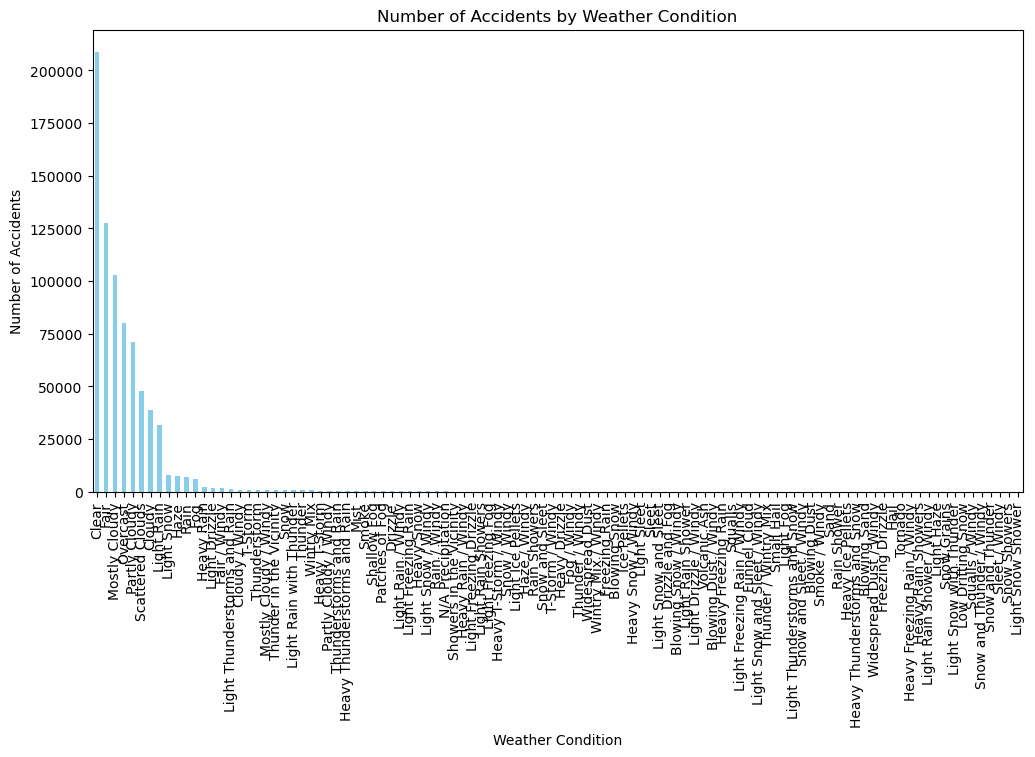

/var/folders/wp/65k6439d1cl97tv8jlm9kgk40000gn/T/ipykernel_95309/347601112.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_severity = df_cleaned.groupby('Weather_Condition')['Severity'].mean().sort_values(ascending=False)


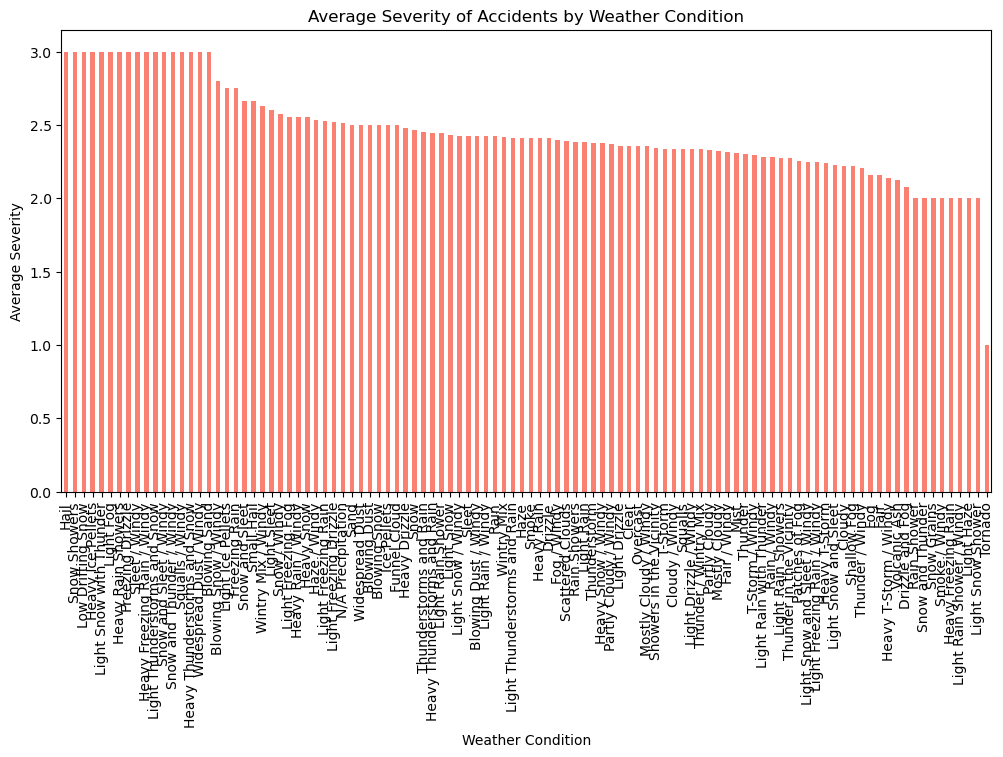

In [13]:
# Bar graph for weather conditions vs number of accidents
weather_accidents = df_cleaned.groupby('Weather_Condition')['ID'].count().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
weather_accidents.plot(kind='bar', color='skyblue')
plt.title("Number of Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=90)
plt.show()

# Bar graph for weather conditions vs severity of accidents
weather_severity = df_cleaned.groupby('Weather_Condition')['Severity'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
weather_severity.plot(kind='bar', color='salmon')
plt.title("Average Severity of Accidents by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Average Severity")
plt.xticks(rotation=90)
plt.show()

/var/folders/wp/65k6439d1cl97tv8jlm9kgk40000gn/T/ipykernel_42496/1068085230.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_accidents = df_cleaned.groupby('State')['ID'].count().sort_values(ascending=False)


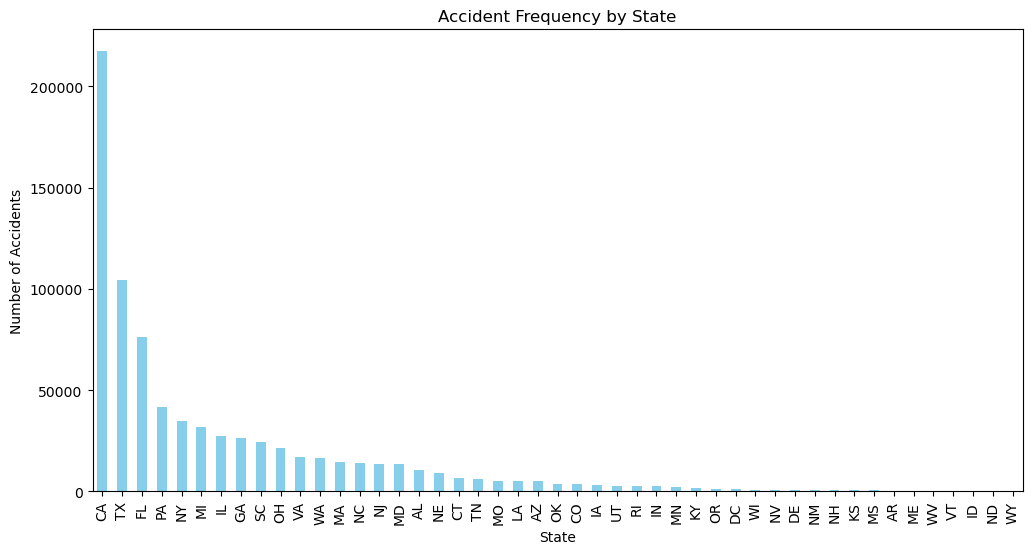

In [37]:
# Accident frequency by state
state_accidents = df_cleaned.groupby('State')['ID'].count().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
state_accidents.plot(kind='bar', color='skyblue')
plt.title("Accident Frequency by State")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=90)
plt.show()

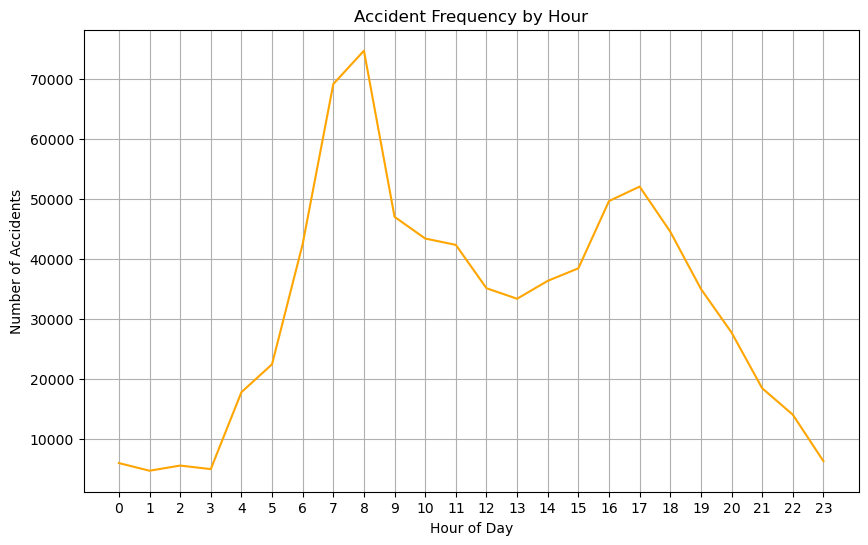

In [42]:
# Accident frequency by hour
df_cleaned['Hour'] = df_cleaned['Start_Time'].dt.hour
hourly_accidents = df_cleaned.groupby('Hour')['ID'].count()
plt.figure(figsize=(10, 6))
hourly_accidents.plot(kind='line', color='orange')
plt.title("Accident Frequency by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.xticks(ticks=range(0, 24), labels=range(0, 24))
plt.grid()
plt.show()

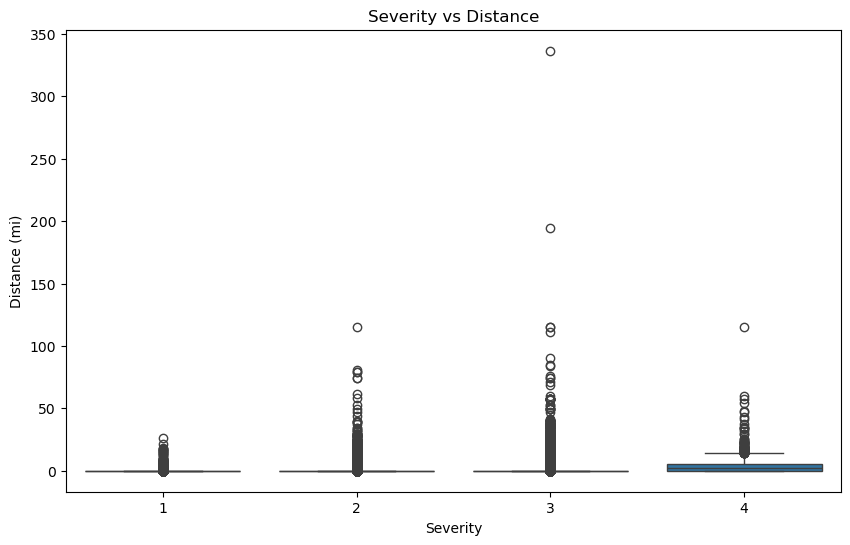

In [46]:
# Boxplot for severity by distance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity', y='Distance(mi)', data=df_cleaned)
plt.title("Severity vs Distance")
plt.xlabel("Severity")
plt.ylabel("Distance (mi)")
plt.show()

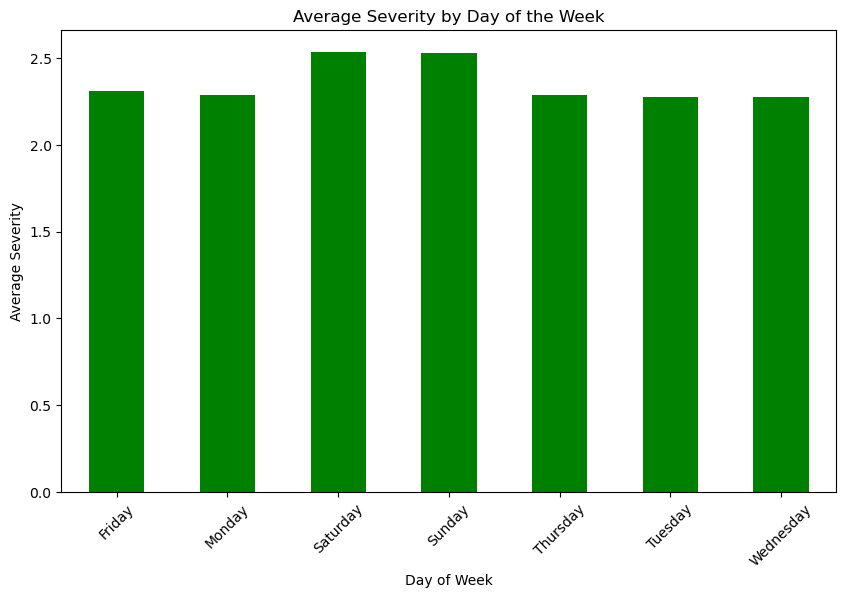

In [49]:
# Severity by day of the week
day_severity = df_cleaned.groupby('Day_of_Week')['Severity'].mean()
plt.figure(figsize=(10, 6))
day_severity.plot(kind='bar', color='green')
plt.title("Average Severity by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Severity")
plt.xticks(rotation=45)
plt.show()

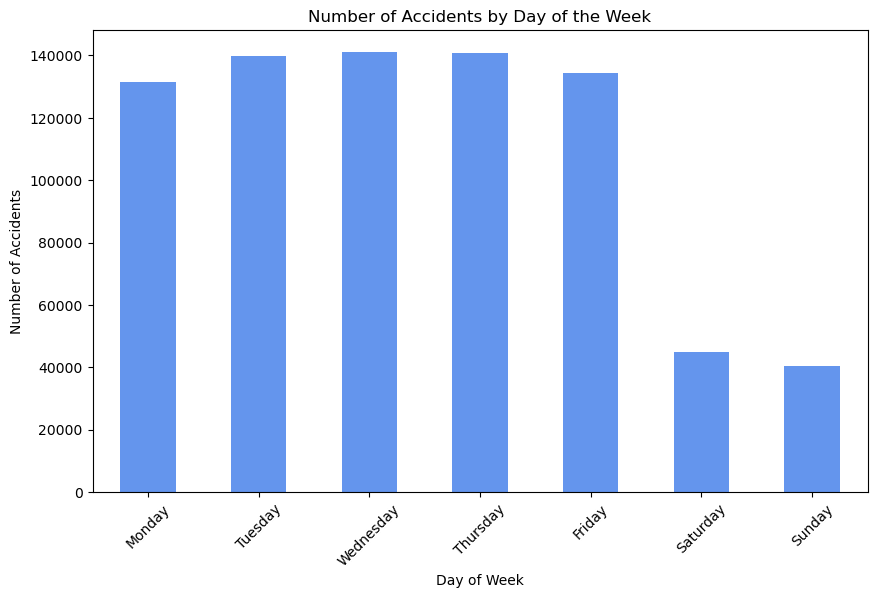

In [50]:
# Number of accidents by day of the week
accidents_by_day = df_cleaned.groupby('Day_of_Week')['ID'].count().reindex(ordered_days)
plt.figure(figsize=(10, 6))
accidents_by_day.plot(kind='bar', color='cornflowerblue')
plt.title("Number of Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.show()

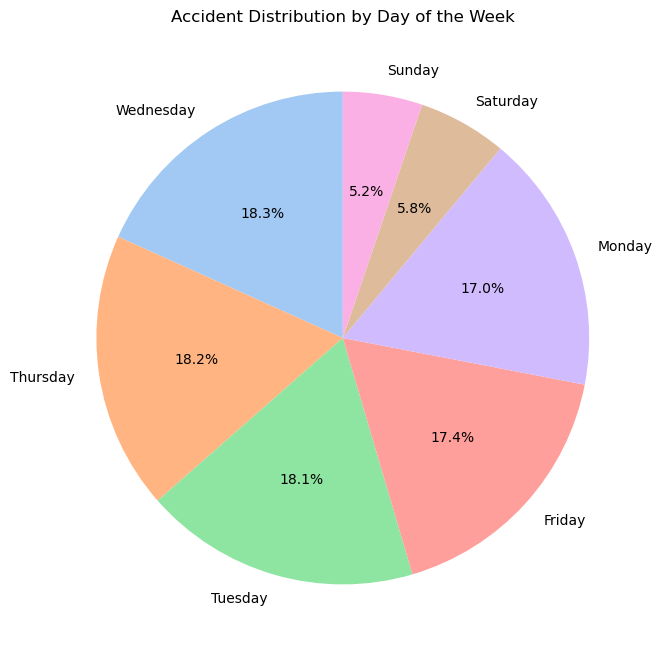

In [59]:
# Pie chart for accident distribution by day of the week
day_counts = df_cleaned['Day_of_Week'].value_counts()
plt.figure(figsize=(8, 8))
day_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Accident Distribution by Day of the Week")
plt.ylabel("") 
plt.show()

In [52]:
# Create a contingency table for Day_of_Week and Severity
contingency_table = pd.crosstab(df_cleaned['Day_of_Week'], df_cleaned['Severity'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

Chi-Square Test Results:
Chi2 Statistic: 14785.97388667666
P-value: 0.0
Degrees of Freedom: 18


There is a statistically significant relationship between the day of the week and accident severity. This means that accident severity varies depending on the day of the week.

In [54]:
# Group severity by day of the week
groups = [df_cleaned[df_cleaned['Day_of_Week'] == day]['Severity'] for day in df_cleaned['Day_of_Week'].unique()]

# Perform ANOVA
anova_stat, anova_p = f_oneway(*groups)

print("ANOVA Test Results:")
print(f"F-Statistic: {anova_stat}")
print(f"P-value: {anova_p}")
import models.api as sm
print(f"P-value: {anova_p}")

ANOVA Test Results:
F-Statistic: 2478.1381693951475
P-value: 0.0


 Accident severity differs significantly across days of the week. This supports the conclusion from the Chi-Square test that the day of the week influences accident severity.

In [ ]:

# Prepare data for regression
X = df_cleaned[['Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 'Humidity(%)']]
y = df_cleaned['Severity']

# Add constant to predictor variables
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Severity   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2690.
Date:                Sat, 12 Jul 2025   Prob (F-statistic):               0.00
Time:                        09:36:07   Log-Likelihood:            -6.5034e+05
No. Observations:              772839   AIC:                         1.301e+06
Df Residuals:                  772834   BIC:                         1.301e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6447      0.005    525.

Environmental factors have weak correlations with accident severity, suggesting that other factors may play a larger role.

## Evaluation

### Business Insight/Recommendation 1

### Recommendation 1: Implement Targeted Safety Measures During High-Risk Days
#### Data-Driven Insight:
- The Chi-Square and ANOVA tests show that accident severity varies significantly across days of the week, with weekends having slightly higher severity levels.
#### Specific Action:
- Increase law enforcement presence and deploy traffic calming measures (e.g., speed cameras, checkpoints) during weekends.
- Conduct public awareness campaigns targeting weekend drivers about the risks of speeding and impaired driving.
#### Potential Impact:
- Reduced accident severity and frequency during weekends, leading to fewer fatalities and injuries.
#### Effectiveness Measurement:
- Track the number of accidents and severity levels on weekends before and after implementing measures.
- Compare accident trends across weekdays and weekends over time.
#### Challenges:
- Resistance from drivers to increased enforcement.
- Budget constraints for deploying additional resources.


### Business Insight/Recommendation 2

### Recommendation 2: Improve Infrastructure in High-Frequency States
#### Data-Driven Insight:
- States like California, Texas, and Florida have the highest accident frequencies, as shown in the "Accident Frequency by State" analysis.
#### Specific Action:
- Prioritize funding for road infrastructure improvements in high-accident states, such as better lighting, signage, and intersection redesigns.
- Conduct localized studies to identify accident hotspots and address specific issues (e.g., poor visibility or road conditions).
#### Potential Impact:
- Reduced accident frequency in high-risk states, improving public safety and reducing economic losses.
#### Effectiveness Measurement:
- Monitor accident rates in targeted states before and after infrastructure improvements.
- Evaluate changes in accident severity levels in these areas.
#### Challenges:
- Long timelines for infrastructure projects.
- Coordination between state and federal agencies for funding and implementation.

### Business Insight/Recommendation 3

### Recommendation 3: Focus on Rush Hour Accident Prevention
#### Data-Driven Insight:
- The "Accident Frequency by Hour" analysis shows peaks during morning (7-9 AM) and evening (4-6 PM) rush hours.
#### Specific Action:
- Implement staggered work hours or encourage remote work policies to reduce traffic congestion during peak hours.
- Deploy traffic management systems (e.g., adaptive traffic signals) to improve flow during rush hours.
#### Potential Impact:
- Reduced accident frequency during rush hours, leading to safer commuting conditions.
#### Effectiveness Measurement:
- Compare accident rates during rush hours before and after implementing measures.
- Track changes in traffic congestion levels during peak hours.
#### Challenges:
- Resistance from businesses to adopt staggered work hours.
- High costs for deploying advanced traffic management systems.

Environmental Factors:

Weak correlations suggest that accident severity is influenced more by human or infrastructure factors than weather conditions.
Geographic Trends:

States with high accident frequency may benefit from targeted infrastructure improvements or policy changes.
Temporal Trends:

Rush hours are critical periods for accident prevention strategies, while midday hours may represent safer driving conditions.
Severity Patterns:

Urban areas or intersections might be hotspots for severe accidents, as indicated by shorter distances.
Weekend vs Weekday Severity:

Both weekdays and weekends require attention for accident prevention, as severity levels are comparable.

### [Tableau Dashboard link](https://public.tableau.com/app/profile/patrick.little2256/viz/Project1Capstone_17523661918000/Dashboard2?publish=yes)


In [57]:
# Export cleaned data to CSV for Tableau
df_cleaned.to_csv('./Data/cleaned_US_Accidents_March23.csv', index=False)

## Conclusion
There is a potential correlation between the number of cars on the road and the number of accidents and severity of those accidents. The less cars on the road could lead to more severe accidents, but the more cars on the road lead to more accidents of less severity

#### Day of the Week 
- Accident severity varies significantly across days, with weekends showing slightly higher severity levels. This suggests the need for targeted interventions during weekends.

#### Environmental Factors
- Weak correlations between environmental factors and severity indicate that human behavior and infrastructure may play a larger role in accidents.

#### Geographic Trends
- States like California, Texas, and Florida experience the highest accident frequencies, highlighting the need for localized infrastructure improvements.

#### Traveling Time
- Rush hours are critical periods for accident prevention strategies, as accident frequency peaks during these times.

#### Severity Patterns
- Longer distances traveled are associated with higher accident severity, suggesting the need for measures to address fatigue and speeding.

## Nest Steps

#### Expand the Dataset
- Analyze the full dataset instead of a subset to ensure comprehensive insights.
- Include other data sets that include things like how many people are on the road and what kind of cars are getting in accidents.

#### Advanced Modeling
- Use machine learning models to predict accident severity based on multiple factors.
- Perform feature importance analysis to identify the most influential variables 

#### Policy Recommendations
- Quantify the potential impact of interventions.
- Collaborate with stakeholders to implement and monitor these measures.
